In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import essay_analysis as ea
import re
from string import punctuation
from collections import OrderedDict, defaultdict, Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer, RegexpStemmer
from sklearn.decomposition import NMF, PCA, LatentDirichletAllocation
from scipy.spatial.distance import pdist, squareform, cosine, euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
from scipy.misc import comb
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import seaborn as sns
import cPickle as pickle
from scipy.stats import ttest_ind
from itertools import combinations
import networkx as nx
import json
import mpld3
%matplotlib inline

In [2]:
df = pd.read_csv('../data/master_essay.csv', low_memory=False)

In [3]:
df[df['essay_final'].notnull()]['top_school_final'].value_counts()

0    2126
1    1051
Name: top_school_final, dtype: int64

In [4]:
df2 = df[df['essay_final'].notnull()].copy()

In [5]:
essays = df2['essay_final'].values.copy()
essays_idx = df2['id'].values
X = essays.copy()
y = df2['top_school_final'].values

### Stop Words & Stemming/Lemmatizing

1. Let's remove ASCII characters to avoid UnicodeDecodeErrors later.
2. We should remove stop words before stemming / lemmatizing (e.g. PorterStemmer turns 'was' into 'wa')
3. Stemming is better than Lemmatizing in our case, because we don't really need to preserve contextual meanings - it's more important that we group words that mean the same thing even if they take different forms. For instance, using a PorterStemmer, if we stem 'familial' and 'family', we get the 'famili' root word in both cases. However, with a WordNetLemmatizer, the output is distinct - it returns 'familial' and 'family'. Since we will eventually build a tfidf matrix, it is preferable to use a PorterStemmer here.

In [6]:
reload(ea)
ae = ea.AnalyzeEssays()

In [7]:
ae.stopWordsAndStem(X)

essay_analysis.py:170: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  essay = ' '.join([word for word in essay.split() if word not in self.stop_words])
/Users/MikeYung/anaconda/lib/python2.7/site-packages/nltk/stem/porter.py:274: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if word[-1] == 's':


### Transform Essays into TFIDF Matrix

In [8]:
# essays[10]

In [9]:
vec = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=10000)
mat = vec.fit_transform(X)

In [10]:
mat

<3177x10000 sparse matrix of type '<type 'numpy.float64'>'
	with 582653 stored elements in Compressed Sparse Row format>

### Visualize TFIDF against Acceptance (using PCA)

Goal: reduce the dimensions from 27k to 2, and visualize in a scatter plot.

In [10]:
pca = PCA(n_components=2)
pca.fit(mat.toarray())
mat_pca = pca.transform(mat.toarray())

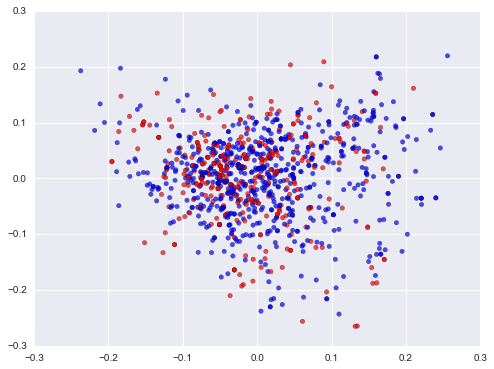

In [13]:
rand_idx = np.random.randint(0, len(X), 1000)
plt.figure(figsize=(8,6))
plt.scatter(mat_pca[rand_idx,0], mat_pca[rand_idx,1], alpha=0.7, s=20, c=y[rand_idx], cmap='bwr')

Not much to see here...

### Visualize using TSNE (t-Distributed Stochastic Neighbor Embedding)

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html <br>
Author recommends performing an inital round of dimensionality reduction first before doing TSNE. In our case, we will will NMF to reduce the data to 10 components first.

In [14]:
dr = ea.dimReduction()
mat_tsne = dr.getTSNE(NMF, 10, mat)

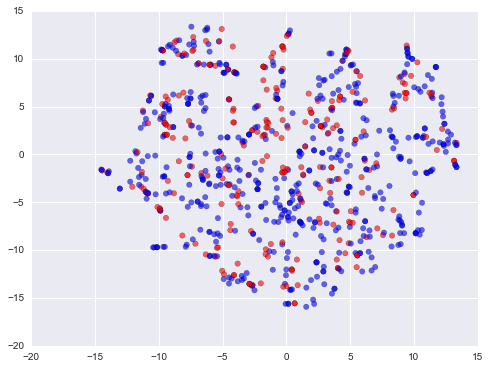

In [15]:
rand_idx = np.random.randint(0, len(X), 800)
plt.figure(figsize=(8,6))
plt.scatter(mat_tsne[rand_idx,0], mat_tsne[rand_idx,1], alpha=0.6, s=30, c=y[rand_idx], cmap='bwr')

Not much here either...

##### If time permits, try TruncatedSVD

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

### Non-Negative Matrix Factorization (NMF)

Chose this over SVD to preserve the interpretability of positive values.

Goal: identify latent features / hidden topics across the essays. May be able to use these as features in our predictive model. We can also compute a cosine similarity matrix: the idea is so we can show most 'similar' essays.

In [11]:
reload(ea)
tm = ea.TopicModeling()

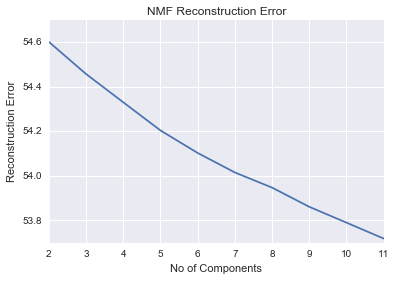

In [12]:
tm.plotOptimalNMF(mat, 12)

Doesn't look like there's any significant 'elbow' in the reconstruction error graph in the first 11 components. Any more than that and we'll likely lose the ability to 'bin'/categorize topics with similar semantic meaning.

After examining the various 'topics' generated from 2-10 topics, we heuristically decide that 7 is the best number. Let's take a look at the key words that represent each of these 7 topics.

In [14]:
nmf = NMF(n_components=7, random_state=100)
nmf.fit(mat)
H = nmf.components_
tm.showTopWords(H, vec, no_words=40)

[array([u'mother', u'father', u'famili', u'parent', u'mom', u'dad', u'life',
        u'brother', u'work', u'sister', u'home', u'live', u'family',
        u'help', u'time', u'day', u'grandmoth', u'care', u'alway', u'want',
        u'cancer', u'dream', u'hous', u'hard', u'children', u'hospit',
        u'job', u'make', u'becam', u'year', u'love', u'sibl', u'age',
        u'support', u'doctor', u'old', u'know', u'child', u'everyth',
        u'money'], 
       dtype='<U17'),
 array([u'music', u'play', u'piano', u'perform', u'song', u'band', u'danc',
        u'note', u'sing', u'stage', u'concert', u'orchestra', u'sound',
        u'guitar', u'jazz', u'piec', u'instrument', u'art', u'listen',
        u'chord', u'emot', u'musician', u'room', u'practic', u'audienc',
        u'content', u'love', u'theater', u'passion', u'feel', u'express',
        u'classic', u'audit', u'performance', u'melodi', u'violin',
        u'choir', u'everi', u'artist', u'piece'], 
       dtype='<U17'),
 array([u'cultur',

Let's now transform our tfidf matrix to get the low-dimensional (7-topic) version of it.

In [15]:
W = nmf.transform(mat)

##### Modeling Tests

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

In [128]:
def test(X,y,model,params):
    gs = GridSearchCV(model, param_grid=params, cv=5)
    gs.fit(X,y)
    print gs.grid_scores_
    y_pred = gs.predict(X)
    print confusion_matrix(y, y_pred)
    print gs.score(X,y)

In [129]:
test(W,y,RandomForestClassifier(), params = {'max_features':[2,3]})

[mean: 0.65313, std: 0.01004, params: {'max_features': 2}, mean: 0.63991, std: 0.00525, params: {'max_features': 3}]
[[2121    5]
 [  73  978]]
0.975448536355


In [131]:
test(W,y,KNeighborsClassifier(), params = {'n_neighbors':range(2,8)})

[mean: 0.64621, std: 0.01103, params: {'n_neighbors': 2}, mean: 0.60875, std: 0.01577, params: {'n_neighbors': 3}, mean: 0.65030, std: 0.01550, params: {'n_neighbors': 4}, mean: 0.63488, std: 0.01887, params: {'n_neighbors': 5}, mean: 0.65628, std: 0.01942, params: {'n_neighbors': 6}, mean: 0.63802, std: 0.02095, params: {'n_neighbors': 7}]
[[2022  104]
 [ 747  304]]
0.732137236387


### Pickle Tfidf-Vectorizer and NMF model

In [105]:
with open('../data/vectorizer.pkl', 'w') as f:
    pickle.dump(vec, f)
with open('../data/nmf.pkl', 'w') as f:
    pickle.dump(nmf, f)

### Export data (containing just essays + topics)

To make things easier when creating an app to recommend similar essays/profiles later on, let's create a new DataFrame containing just essays, topics, and userid.

In [16]:
essays_and_topics = np.hstack((essays_idx.reshape(-1,1), (essays.reshape(-1,1))))
essays_and_topics = np.hstack((essays_and_topics, W))
df_et_cols = ['id','content','family', 'music', 'culture', 'sport', 'personal', 'science', 'career']
df_et = pd.DataFrame(essays_and_topics, columns=df_et_cols)

In [ ]:
df_et.to_csv('../data/essays_and_topics.csv')

In [17]:
df_et.head()

,id,content,family,music,culture,sport,personal,science,career
0,7668,The Art of Living in a Boy House\nStill sleepy...,0.0286212,0.0126327,0,0.0171051,0.0398075,0.0461729,0.000983955
1,7666,Making a Leader\nThe auditorium is filling up....,0.0279414,0,0,0.0103799,0.0790994,0,0.0733329
2,6342,Second nature now kicked in. As I bounced the ...,0.021991,0.0100422,0.02812,0.146277,0,0.00519798,0.00527239
3,7565,I squeezed my arms tighter around my chest as ...,0,0.0834848,0,0.00334936,0.078574,0,0
4,7558,"Growing up in a small, insignificant suburb in...",0.00830832,0.00269371,0.105175,0.00553663,0.0280607,0,0


In [168]:
df_et['id'].astype(int).describe()

count      3177.000000
mean      64952.482216
std       59199.651561
min        6342.000000
25%       24725.000000
50%       49304.000000
75%       68479.000000
max      238095.000000
Name: id, dtype: float64

In [18]:
topics = df_et.columns[2:]

#### Create a % dataframe from df_et

In [19]:
df_et_p = df_et.copy()
for col in df_et.columns[2:]:
    df_et_p[col] = df_et[col]/df_et.ix[:,2:].sum(axis=1)

In [20]:
df_et_p.head()

,id,content,family,music,culture,sport,personal,science,career
0,7668,The Art of Living in a Boy House\nStill sleepy...,0.196948,0.0869284,0,0.117704,0.273923,0.317725,0.00677079
1,7666,Making a Leader\nThe auditorium is filling up....,0.146479,0,0,0.054415,0.414668,0,0.384438
2,6342,Second nature now kicked in. As I bounced the ...,0.101387,0.0462988,0.129645,0.674396,0,0.0239648,0.0243079
3,7565,I squeezed my arms tighter around my chest as ...,0,0.50472,0,0.0202491,0.475031,0,0
4,7558,"Growing up in a small, insignificant suburb in...",0.0554722,0.0179851,0.702224,0.0369664,0.187353,0,0


#### Topics vs Schools

In [21]:
df_merged = pd.merge(df, df_et_p, how='inner', left_on='id', right_on='id')

In [22]:
df_merged_cols = df_et_cols[:]
df_merged_cols.append('top_school_final')

In [23]:
for t in topics:    
    print t
    accepts = df_merged[(df_merged['top_school_final']==1)][t]
    rejects = df_merged[(df_merged['top_school_final']==0)][t]
    print accepts.mean()
    print rejects.mean()
    print ttest_ind(accepts, rejects)

family
0.104296496293
0.118991065869
Ttest_indResult(statistic=-2.4363912375533352, pvalue=0.014889242343970221)
music
0.0758030363628
0.0647409385014
Ttest_indResult(statistic=1.9726334643073709, pvalue=0.048623969900588468)
culture
0.14253405632
0.128969974857
Ttest_indResult(statistic=2.067249444186043, pvalue=0.038791515606065058)
sport
0.103816305761
0.0943291483597
Ttest_indResult(statistic=1.4820752839555444, pvalue=0.13841950404948772)
personal
0.307105579349
0.285164499326
Ttest_indResult(statistic=2.5241583906787666, pvalue=0.011645941889761272)
science
0.138864364083
0.121088411281
Ttest_indResult(statistic=2.7855732404318396, pvalue=0.0053750270000469929)
career
0.127580161831
0.186715961806
Ttest_indResult(statistic=-8.4714314352056004, pvalue=3.6547489618556502e-17)


In [140]:
def printAcceptanceByTopic(df, low_thresh=0.01, mid_thresh=0.33):
    for i,topic in enumerate(topics):
        print topic.upper()
        no_topic = df[df[topic]<low_thresh]['top_school_final']
        low_topic = df[(df[topic]>low_thresh)&(df[topic]<=mid_thresh)]['top_school_final']
        high_topic = df[df[topic]>mid_thresh]['top_school_final']
        
        print 'Least "{}"-oriented essays have an acceptance rate of {}% ({} entries)'.format(
            topic, np.round((no_topic.mean()*100),1), sum(no_topic))
        print 'Less "{}"-oriented essays have an acceptance rate of {}% ({} entries)'.format(
            topic, np.round((low_topic.mean()*100),1), sum(low_topic))
        print 'More "{}"-oriented essays have an acceptance rate of {}% ({} entries)'.format(
            topic, np.round((high_topic.mean()*100),1), sum(high_topic))
        print '\n'

In [141]:
printAcceptanceByTopic(df_merged, low_thresh=0.03, mid_thresh=0.25)

FAMILY
Least "family"-oriented essays have an acceptance rate of 35.9% (505 entries)
Less "family"-oriented essays have an acceptance rate of 31.3% (396 entries)
More "family"-oriented essays have an acceptance rate of 29.6% (150 entries)


MUSIC
Least "music"-oriented essays have an acceptance rate of 30.8% (643 entries)
Less "music"-oriented essays have an acceptance rate of 38.1% (312 entries)
More "music"-oriented essays have an acceptance rate of 35.7% (96 entries)


CULTURE
Least "culture"-oriented essays have an acceptance rate of 30.2% (393 entries)
Less "culture"-oriented essays have an acceptance rate of 33.8% (426 entries)
More "culture"-oriented essays have an acceptance rate of 37.5% (232 entries)


SPORT
Least "sport"-oriented essays have an acceptance rate of 30.8% (500 entries)
Less "sport"-oriented essays have an acceptance rate of 35.6% (416 entries)
More "sport"-oriented essays have an acceptance rate of 35.2% (135 entries)


PERSONAL
Least "personal"-oriented essays

In [24]:
topschools = df.columns[-27:-17].values

In [26]:
def printTopicsBySchool(df, school, thresh=0.5):
    subdf = df[df[school]==1][topics]
    print school.upper(), '({} admitted)'.format(len(subdf))
    for topic in topics:
        rate = len(subdf[subdf[topic]>thresh]) / float(len(subdf))
        print '{}% wrote about {}'.format(np.round(rate*100), topic)

In [27]:
def topicsBySchool(df, school, thresh=0.5):
    subdf = df[df[school]==1][topics]
    rates = []
    rates = map(lambda topic: len(subdf[subdf[topic]>thresh]) / float(len(subdf)) * 100 , topics)
    return rates

In [29]:
topics_by_topschool = map(lambda school: topicsBySchool(df_merged, school, thresh=0.25), topschools)
topschools_short = ['Harvard', 'Yale', 'Cornell', 'Columbia', 'UPenn', 'Princeton', 'Brown', 'Dartmouth', 'MIT', 'Stanford']
df_topschools = pd.DataFrame(topics_by_topschool, columns=topics, index=topschools_short)
df_topschools

,family,music,culture,sport,personal,science,career
Harvard,19.736842,7.236842,23.026316,11.184211,51.315789,16.447368,18.421053
Yale,19.354839,7.258065,23.387097,10.483871,50.806452,19.354839,22.580645
Cornell,12.107623,8.520179,25.112108,16.591928,51.569507,21.076233,21.076233
Columbia,12.500000,10.156250,21.093750,12.500000,52.343750,25.000000,21.875000
UPenn,17.192982,9.473684,26.315789,9.473684,52.631579,15.087719,17.543860
Princeton,15.238095,12.380952,20.000000,14.285714,59.047619,15.238095,17.142857
Brown,20.143885,12.949640,24.460432,7.194245,62.589928,10.071942,20.863309
Dartmouth,18.269231,12.500000,20.192308,15.384615,49.038462,15.384615,19.230769
MIT,14.583333,8.333333,17.708333,13.541667,48.958333,27.083333,18.750000
Stanford,14.917127,8.287293,20.994475,14.364641,53.591160,22.099448,17.127072


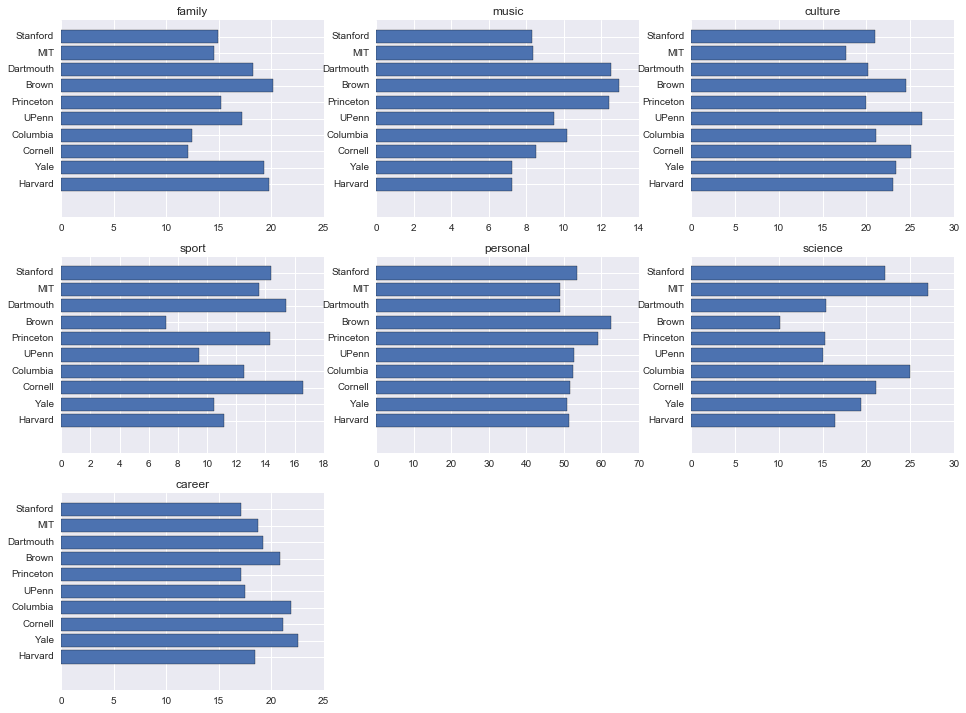

In [32]:
fig = plt.figure(figsize=(16,12))
for i,topic in enumerate(topics):
    plt.subplot(3,3,i+1)
    plt.barh(range(len(df_topschools)), df_topschools[topic], tick_label=df_topschools.index, align='center')
    plt.title(topic)

Couple observations:
- As expected, MIT was more likely than any school to write about Science.
- In general, students tended to write least about Sports and Music. In particular, just 7% of Brown students wrote about Sport, while just 7% of Harvard and Yale students wrote about Music.
- UPenn was more likely than any other school to write about culture, reflecting the vast international student body there.

#### ALL Schools

In [33]:
df_schools = pd.read_csv('../data/all_schools.csv', low_memory=False)
df_schools.drop('Unnamed: 0', axis=1, inplace=True)
df_et_schools = pd.merge(df_et, df_schools, left_on='id', right_on='id')

In [34]:
topics_by_school = map(lambda school: df_et_schools[df_et_schools[school]==1][topics].mean(), df_schools.columns)
df_et_schools_T = pd.DataFrame(topics_by_school , columns=topics, index=df_schools.columns)
df_et_schools_T.drop('id', inplace=True)

In [35]:
df_et_schools_T.head()

,family,music,culture,sport,personal,science,career
"University of Connecticut (Storrs, CT)_final",0.017499,0.009062,0.017981,0.015351,0.058542,0.013474,0.025738
"Carnegie Mellon University (Pittsburgh, PA)_final",0.011490,0.019629,0.023658,0.020052,0.047828,0.031465,0.022866
"University of Massachusetts - Amherst (Amherst, MA)_final",0.014651,0.009550,0.023709,0.019276,0.053931,0.018456,0.030313
"George Washington University (Washington, DC)_final",0.019252,0.009903,0.034077,0.017692,0.046332,0.019400,0.025658
"Williams College (Williamstown, MA)_final",0.028045,0.008686,0.032239,0.014391,0.050503,0.016291,0.022926


### Plot 2-D Representation of Topics

Let's find the best 'K' to color the scatterplot of the reduced 2-D representation we will be plotting.

In [37]:
reload(ea)
ct = ea.ClusterTools()
ct.findBestK(df_et_schools_T, max_k=7)

The best K is 2, with a silhouette score of 0.251662855988.
[(0.25166285598783711, 2), (0.18265567471428668, 3), (0.17139117698540629, 4), (0.15132101196954573, 5), (0.177231003628118, 6), (0.16844008479604231, 7)]


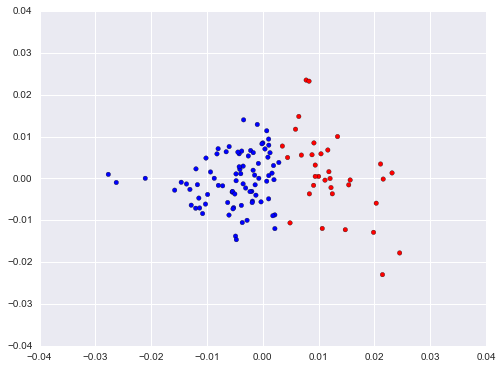

In [38]:
km = KMeans(n_clusters=2)
km.fit(df_et_schools_T)
pca = PCA(n_components=2)
plt.figure(figsize=(8,6))
pca2_schools = pca.fit_transform(df_et_schools_T)
plt.scatter(pca2_schools[:,0], pca2_schools[:,1], c=km.labels_, cmap='bwr')

Even though k=2 has the highest silhouette score, let's see if we get visual separation with k=3.

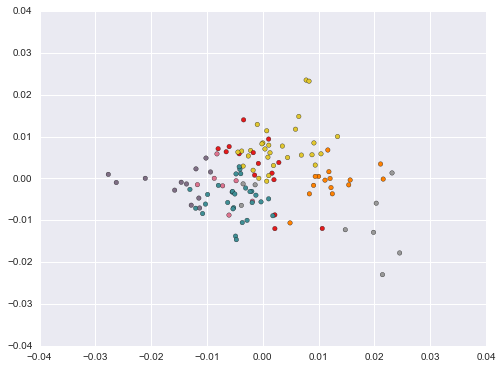

In [137]:
km = KMeans(n_clusters=7)
km.fit(df_et_schools_T)
df_et_schools_T['cluster'] = km.labels_
pca = PCA(n_components=2)
plt.figure(figsize=(8,6))
pca2_schools = pca.fit_transform(df_et_schools_T.iloc[:,:-1])
plt.scatter(pca2_schools[:,0], pca2_schools[:,1], c=km.labels_, cmap='Set1')

In [90]:
# Inspect the schools in each cluster:
# sorted(df_et_schools_T[df_et_schools_T['cluster']==0].index)

In [140]:
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""
    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [143]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=pca2_schools[:,0], y=pca2_schools[:,1], label=km.labels_, title=all_schools))

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -100px;
margin-right: -100px}
"""

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: 'b', 6: 'g', 7:'r'}

#set up cluster names using a dict
cluster_names = {0: '0', 
                 1: '1', 
                 2: '2',
                3: '3',
                4: '4',
                5: '5',
                6: '6',
                7: '7'}

In [146]:
# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

### Calculate Weights for Graph

In [43]:
all_schools = df_et_schools_T.index
combos = list(combinations(all_schools, 2))

In [51]:
school_dist = pairwise_distances(df_et_schools_T.iloc[:,:-1])
school_dict = {school:i for i,school in enumerate(all_schools)}
school_weights = []
for s1, s2 in combos:
    school_weights.append((s1, s2, school_dist[school_dict[s1]][school_dict[s2]]))

In [52]:
df_graph = pd.DataFrame(school_weights, columns=['s1','s2','weight'])
df_graph.head()

,s1,s2,weight
0,"University of Connecticut (Storrs, CT)_final","Carnegie Mellon University (Pittsburgh, PA)_final",0.025472
1,"University of Connecticut (Storrs, CT)_final",University of Massachusetts - Amherst (Amherst...,0.011117
2,"University of Connecticut (Storrs, CT)_final","George Washington University (Washington, DC)_...",0.021273
3,"University of Connecticut (Storrs, CT)_final","Williams College (Williamstown, MA)_final",0.019901
4,"University of Connecticut (Storrs, CT)_final","University of Florida (Gainesville, FL)_final",0.025360


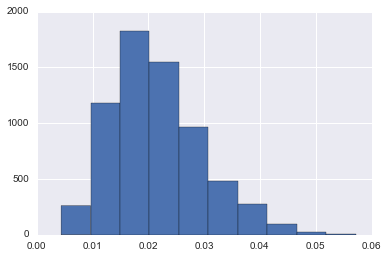

In [84]:
# _=plt.boxplot(df_graph['weight'])
df_graph['weight'].hist()

In [54]:
df_graph2 = df_graph[df_graph['weight']>0.03].copy()
len(df_graph2)

975

In [276]:
df_graph2.to_csv('../data/graph_weights.tsv',sep='\t')

In [77]:
links = []
for s1,s2,weight in school_weights:
    if weight > 0.04:
        temp_dict = {'source':s1, 'target':s2, 'value':weight}
        links.append(temp_dict)

In [68]:
nodes = []
for school in all_schools:
    temp_dict = {'id': school, 'group': df_et_schools_T.loc[school,'cluster']}
    nodes.append(temp_dict)

In [79]:
json_output = {'nodes': nodes, 'links': links}
with open('../data/d3_weights.json', 'w') as f:
    json.dump(json_output, f)

#### Distribution of Topics

In [280]:
# _=pd.scatter_matrix(df_et_schools_T.astype(float), figsize=(15,12))

### Export Tfidf Matrix (for recommending essays)

In [124]:
with open('../data/tfidf_mat.pkl', 'w') as f:
    pickle.dump(mat, f)

### Experimenting with Latent Dirichlet Allocation (LDA)

In [253]:
count_vec = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=10000)
count_mat = count_vec.fit_transform(X)

In [254]:
count_mat

<3177x10000 sparse matrix of type '<type 'numpy.int64'>'
	with 582653 stored elements in Compressed Sparse Row format>

In [289]:
lda = LatentDirichletAllocation(n_topics=7, max_iter=50)
lda.fit(count_mat)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=1, n_topics=5, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [290]:
W_lda = lda.transform(count_mat)

In [291]:
H_lda = lda.components_
tm.showTopWords(H_lda, count_vec, 40)

[array([u'learn', u'world', u'cultur', u'differ', u'experi', u'research',
        u'new', u'student', u'scienc', u'american', u'school',
        u'understand', u'music', u'english', u'use', u'art', u'languag',
        u'studi', u'passion', u'creat', u'class', u'comput', u'program',
        u'thi', u'mani', u'allow', u'develop', u'design', u'speak', u'like',
        u'commun', u'question', u'engin', u'chines', u'knowledg', u'human',
        u'explor', u'peopl', u'work', u'idea'], 
       dtype='<U17'),
 array([u'world', u'like', u'time', u'life', u'day', u'feel', u'new',
        u'peopl', u'way', u'everi', u'make', u'place', u'know', u'book',
        u'read', u'look', u'want', u'im', u'love', u'home', u'ive',
        u'alway', u'stori', u'someth', u'live', u'think', u'year', u'thing',
        u'dont', u'write', u'mind', u'friend', u'water', u'littl', u'old',
        u'word', u'long', u'creat', u'thought', u'thi'], 
       dtype='<U17'),
 array([u'life', u'school', u'help', u'work', u'wa